In [1]:
import sys, os
insert_path = os.path.dirname(os.path.abspath(""))
sys.path.insert(0, insert_path)

In [2]:
from model.models.threes import ThreesModel
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from model.nba_api_helpers import get_player_shot_loc_data, get_league_shot_loc_data, generate_3_point_classifier
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import GridSearchCV
from model.utils.plotting import draw_court
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text

In [3]:
font_path = os.path.join(os.path.abspath(os.path.dirname("")), "assets/fonts")
style_path = os.path.join(os.path.abspath(os.path.dirname("")), "assets/stylesheets/nba.mplstyle")
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

if os.path.isfile(style_path):
    plt.style.use(style_path)
else:
    print('Could not locate style sheet')

In [4]:
player_name = "Jordan Poole"
opponent = "LAL"

In [5]:
clf = generate_3_point_classifier()

In [6]:
bootstrap_samples = 100_000
player_df = get_player_shot_loc_data(player_name, context_measure_simple='FG3A')
threes = player_df.loc[:, ['GAME_ID', 'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG', 'SHOT_ATTEMPTED_FLAG']]
threes = threes.dropna()

threes['SHOT_MADE_FLAG'] = threes['SHOT_MADE_FLAG'].astype(np.int64)

threes_train_xy = threes[['LOC_X', 'LOC_Y']].values.reshape(-1, 2)
fga_per_game_data = threes.groupby('GAME_ID')['SHOT_ATTEMPTED_FLAG'].count().values

#get league shot data

league_df = get_league_shot_loc_data(context_measure_simple='FG3A')
league_test_xy = league_df[['LOC_X', 'LOC_Y']].values.reshape(-1, 2)

param_grid = {
    "n_components": range(3, 15),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GMM(), param_grid=param_grid, scoring=lambda estimator, x: -estimator.bic(x)
)

grid_search.fit(threes_train_xy)

covariance_type = grid_search.best_params_['covariance_type']
n_components = grid_search.best_params_['n_components']
model = GMM(n_components=n_components, covariance_type=covariance_type, random_state=0).fit(threes_train_xy)

model_labels_ = model.predict(threes_train_xy)

league_model_labels_ = model.predict(league_test_xy)
league_df['cluster'] = league_model_labels_

#filter for opponent after assigning clusters
opponent_df = league_df.loc[league_df['DEF'] == opponent]

#create a dataframe from the cluster data dictionary
cluster_df = pd.DataFrame({
    'shot_made': threes['SHOT_MADE_FLAG'],
    'cluster': model_labels_
})

#shooting percentage by cluster
fg_percent_by_cluster = pd.DataFrame(cluster_df.groupby('cluster')['shot_made'].value_counts(normalize=True)).rename({'shot_made': 'fg_percent'}, axis=1).reset_index()
fg_percent_by_cluster = fg_percent_by_cluster.loc[fg_percent_by_cluster['shot_made'] == 1].drop('shot_made', axis=1)['fg_percent']

#league fg% by cluster
league_fg_percent_by_cluster = pd.DataFrame(league_df.groupby('cluster')['SHOT_MADE_FLAG'].value_counts(normalize=True)).rename({'SHOT_MADE_FLAG': 'fg_percent'}, axis=1).reset_index()
league_fg_percent_by_cluster = league_fg_percent_by_cluster.loc[league_fg_percent_by_cluster['SHOT_MADE_FLAG'] == 1].drop('SHOT_MADE_FLAG', axis=1)['fg_percent']

#opponent def fg% by cluster
opponent_fg_percent_by_cluster = pd.DataFrame(opponent_df.groupby('cluster')['SHOT_MADE_FLAG'].value_counts(normalize=True)).rename({'SHOT_MADE_FLAG': 'fg_percent'}, axis=1).reset_index()
opponent_fg_percent_by_cluster = opponent_fg_percent_by_cluster.loc[opponent_fg_percent_by_cluster['SHOT_MADE_FLAG'] == 1].drop('SHOT_MADE_FLAG', axis=1)['fg_percent']

#opponent defensive ratings per cluster relative to league average
def_adjustment = opponent_fg_percent_by_cluster / league_fg_percent_by_cluster

#bootstrap resample from FGA data to find normal distribution fo estimated mean FGA per game
fga_per_game_est = [np.random.choice(fga_per_game_data, size=len(fga_per_game_data), replace=True).mean() for _ in range(bootstrap_samples)]
fga_per_game_est_mean = np.mean(fga_per_game_est)
fga_per_game_est_std = np.std(fga_per_game_est)

In [1]:
def sim_and_plot(save=False, file_name=None):
        fig, axes = plt.subplots(3, 3, figsize=(12, 12))
        plt.style.use('ggplot')

        red = "#E74C3C"
        green = "green"
        grey = "#4E616C"
        fc = 'white'
        box_padding = 3

        for row in axes:
            for i, ax in enumerate(row):
                #simulate FGA
                fga_i = np.random.poisson(np.random.normal(fga_per_game_est_mean, fga_per_game_est_std))
                sampled_shot_locs = np.array([])
                fgms = 0
                for fga in range(fga_i):
                    selected_cluster = np.random.choice(np.arange(0, n_components), p=model.weights_)
                    not_3_point_shot = True
                    while not_3_point_shot:
                        sampled_shot = np.random.multivariate_normal(
                            model.means_[selected_cluster], model.covariances_[selected_cluster]
                        )
                        three_point_shot = clf.predict([sampled_shot])[0]
                        not_3_point_shot = not three_point_shot

                    proba = model.predict_proba(sampled_shot.reshape(-1, 2)).T
                    weighted_fg_percent = np.dot(def_adjustment*fg_percent_by_cluster.values, proba)
                    fgm_i = np.vectorize(np.random.binomial)(1, weighted_fg_percent)[0]
                    fgms += fgm_i
                    if fgm_i: #make
                         ax.scatter(x=sampled_shot[0], y=sampled_shot[1], color=green, alpha=0.5, edgecolor=green, lw=2, s=75)
                    else:
                          ax.scatter(x=sampled_shot[0], y=sampled_shot[1], color=red, marker='x',  alpha=0.8, lw=2, s=75)
                draw_court(ax=ax, lw=2.5, color="#4E616C")
                sim_num = (np.random.choice(range(100000)))
                sim_num = '{:,}'.format(sim_num)
                ax.set_title(f'Simulation #{sim_num}', color=grey, fontweight='semibold')

                if fgms < 3.5:
        #             ax.set_title(f'Sim #{np.random.choice(range(100000))}, FGM={fgms}/{fga_i}', fontweight="bold", color=red) 
                    ax_text(
                        x = 0.9,
                        y = 1.085,
                        s = f'<{fgms} / {fga_i}>',
                        ax = ax, 
                        highlight_textprops=[
                            {'size':'12', 'bbox': {'edgecolor': red, 'facecolor': red, 'pad': box_padding}, 'color': 'white'},
                        ],
                        font = 'Lato', 
                        ha = 'left', 
                        size = 14, 
                        annotationbbox_kw = {'xycoords':'axes fraction'}
                    )

                else:
                    ax_text(
                        x = 0.9, 
                        y = 1.085,
                        s = f'<{fgms} / {fga_i}>',
                        ax = ax, 
                        highlight_textprops=[
                            {'size':'12', 'bbox': {'edgecolor': green, 'facecolor': green, 'pad': box_padding}, 'color': 'white'},
                        ],
                        font = 'Lato', 
                        ha = 'left', 
                        size = 14, 
                        annotationbbox_kw = {'xycoords':'axes fraction'}
                    )
                ax.grid(True, zorder=1000);
                ax.set_xticks([]); ax.set_yticks([])
        #         ax.set_facecolor("#EFE9E6")
                ax.set_facecolor(fc)
        #         fig.set_facecolor("#EFE9E6")
                fig.set_facecolor(fc)
                for spine in ax.spines.values():
                    spine.set_edgecolor(grey)

        fig_text(
            x=0.12, y=.96, s="<Python Threes Model>: 9/100,000 sampled simulations of Jordan Poole vs. LAL", highlight_textprops=[{'weight':'bold', 'color': "#202f52"}], fontsize=18);
        fig_text(
            x=0.12, y=.92, 
            s='Under 3.5 3-Point Field Goals <(-140)> on Draftkings, <+EV: 0.24, 15.5% Edge> | viz by @bendominguez011',
            highlight_textprops=[{'weight':'bold', 'color': "#202f52"}, {'weight': 'bold', 'color':green}],
            va='bottom', ha='left',
            fontsize=13, color='#4E616C', font='Lato'
        );
        
        if save:
            plt.savefig(f'{file_name}.png', pad_inches=0)
        else:
            plt.show()

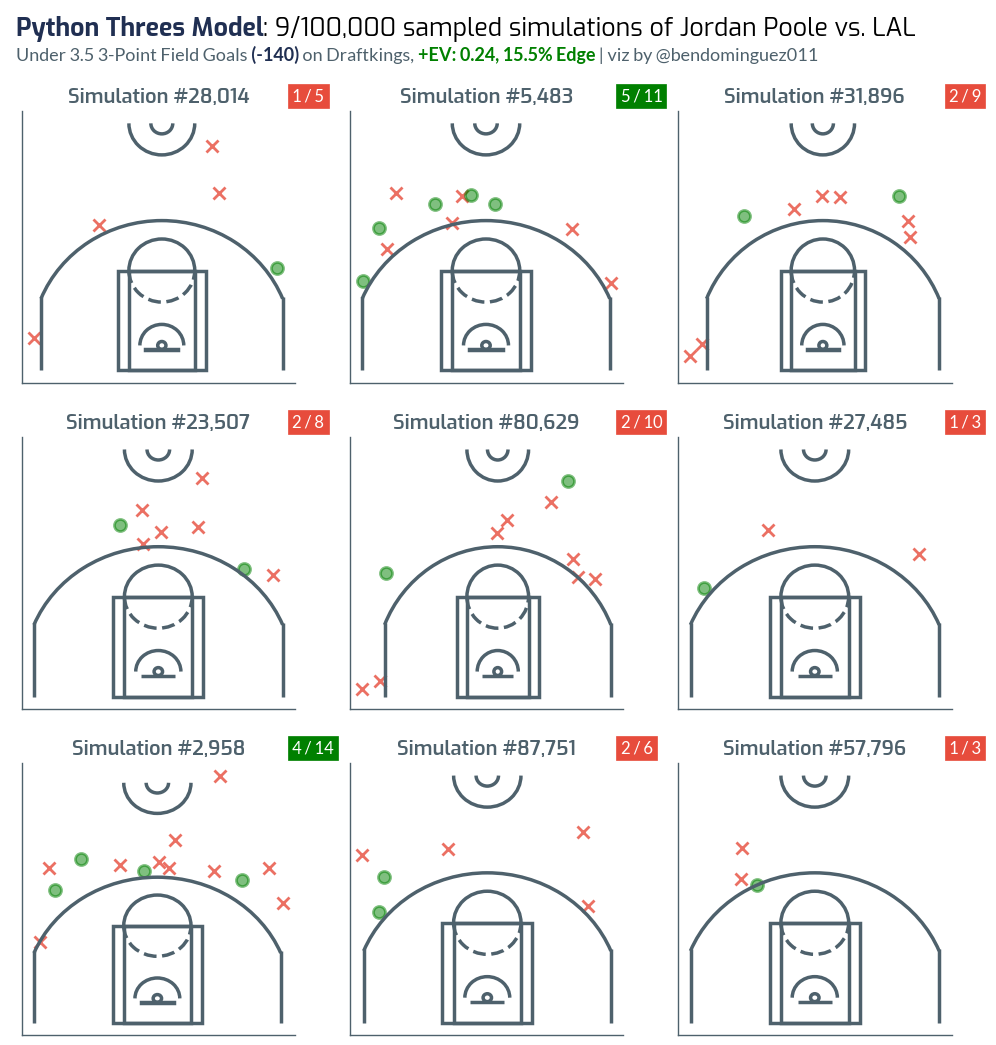

In [12]:
sim_and_plot()